# Example: Crosstalk Methodology

Last Verified to Run: 2021-06-08\
Verified Stack Release: v21.0.0

## Introduction

The purpose of this notebook is to demonstrate the methodology used by the MixCOATL crosstalk analysis to calculate the crosstalk ratio results between amplifier pairs. This is done by using the Butler to obtain an example image from a Gen 3 repository and then running the crosstalk analysis code that is implemented in `mixcoatl.crosstalkTask.crosstalkSatelliteTask`.

For a detailed example on interacting with a Gen 3 repository and exploring the crosstalk analysis data products, see the notebook `Example_CrosstalkResults.ipynb`.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+272aa73355 	current w_2021_23 setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

## DM Stack imports
from lsst.daf.butler import Butler
from lsst.ip.isr import CrosstalkCalib

## MixCOATL imports
import mixcoatl.crosstalk as mixCrosstalk

## Gen 3 repo
repo = '/project/asnyder/LSST-UCDCam/butler.yaml'

## Utility dictionary
DAVIS_AMP2SEG = {1 : 'C17', 2 : 'C16', 3 : 'C15', 4 : 'C14', 5 : 'C13', 6 : 'C12', 7 : 'C11', 8 : 'C10',
                 9 : 'C00', 10 : 'C01', 11 : 'C02', 12 : 'C03', 13 : 'C04', 14 : 'C05', 15 : 'C06', 16 : 'C07'}
DAVIS_SEG2AMP = {DAVIS_AMP2SEG[key] : key for key in DAVIS_AMP2SEG.keys()}

## 1. Calibrate Image

The first step of the crosstalk analysis is to generate the appropriate calibration products. Because we are calculating the electronic crosstalk from a ratio of aggressor and victim amplifiers in units of ADU, the calibration procudure consists of row-by-row subtraction of the image overscan signal, subtraction of a medium stacked superbias image, and assembly of the full CCD image from the individual amplifier images.

The example raw image used in this notebook is an image of a bright satellite streak projected on a single CCD taken at UC Davis using the LSST Camera Optical Beam Simulator (https://arxiv.org/abs/1411.5667), which was taken on 2021-04-27 during a long data acquisition run to study crosstalk ratios as a function of crosstalk source signal. 

In [3]:
butler = Butler(repo, collections='LSST-UCDCam/raw/all')
registry = butler.registry

## Query for raw images taken on 2021-04-27
datasetRefs = list(registry.queryDatasets('raw', where="exposure.observation_type='spot' AND exposure.day_obs=20210427"))
print('Number of images: {0}'.format(len(datasetRefs)))

Number of images: 1867


The query of the data repository shows a large number of images taken on 2021-04-27. The example image was selected to be an image where the signal of the projected satellite streak is large enough for the resulting crosstalk to be visibile in the calibrated image. The `raw` image is displayed below; the differences in the individual amplifier electronic offset values as well as the overscan pixel regions is visible, resulting in the discontinuities between the CCD segment regions.

/project/asnyder/LSST-UCDCam/LSST-UCDCam/raw/all/raw/20210427/E2V-CCD250-112-09_spot_spot_1999_20210427145256/raw_LSST-UCDCam_r_E2V-CCD250-112-09_spot_spot_1999_20210427145256_R00_S00_LSST-UCDCam_raw_all.fits(E2V-CCD250-112-09_spot_spot_1999_20210427145256): Unable to determine dark time. Setting from exposure time.


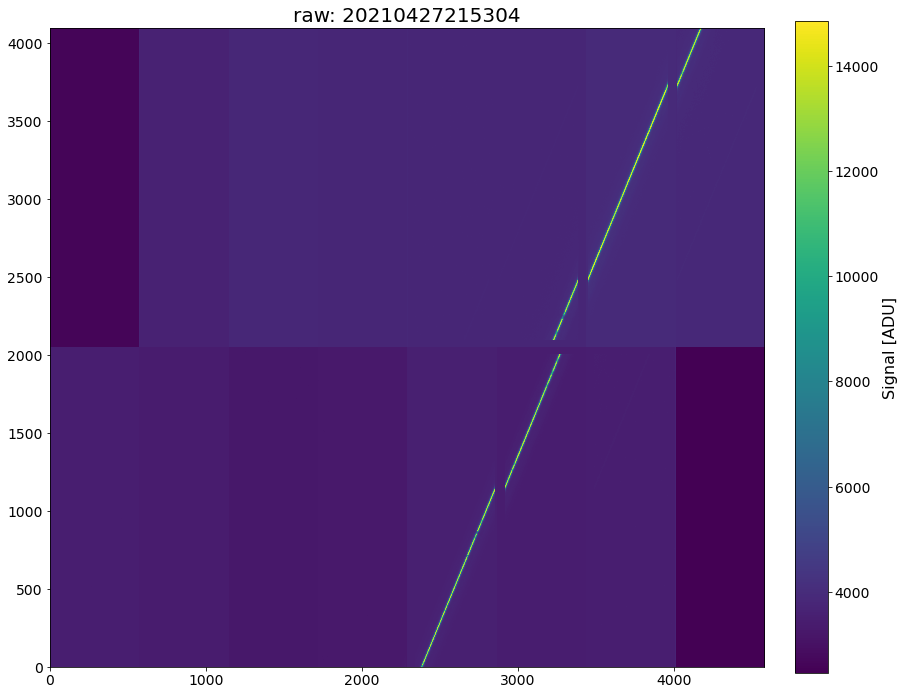

In [4]:
## Get raw image
ref = datasetRefs[1000]
rawexp = butler.get('raw', dataId=ref.dataId, collections='LSST-UCDCam/raw/all')

## Display raw image
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
im = ax.imshow(rawexp.getImage().getArray(), origin='lower', interpolation='none')

cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('raw: {0}'.format(ref.dataId['exposure']), fontsize=20)
fig.patch.set_facecolor('white')

Calibration of the above raw image was performed using the DM stack task `lsst.ip.isr.isrTask.IsrTask`. The corresponding calibrated exposure is displayed below, now with overscan regions trimmed and electronic offsets of the individual amplifiers removed by the calibration procedure. A symmetric logarithmic color scale is used in order to allow the induced crosstalk signal to be visible without the bright satellite streak saturating the color scale. Additionally, the segment boundaries have been plotted over the image in white.

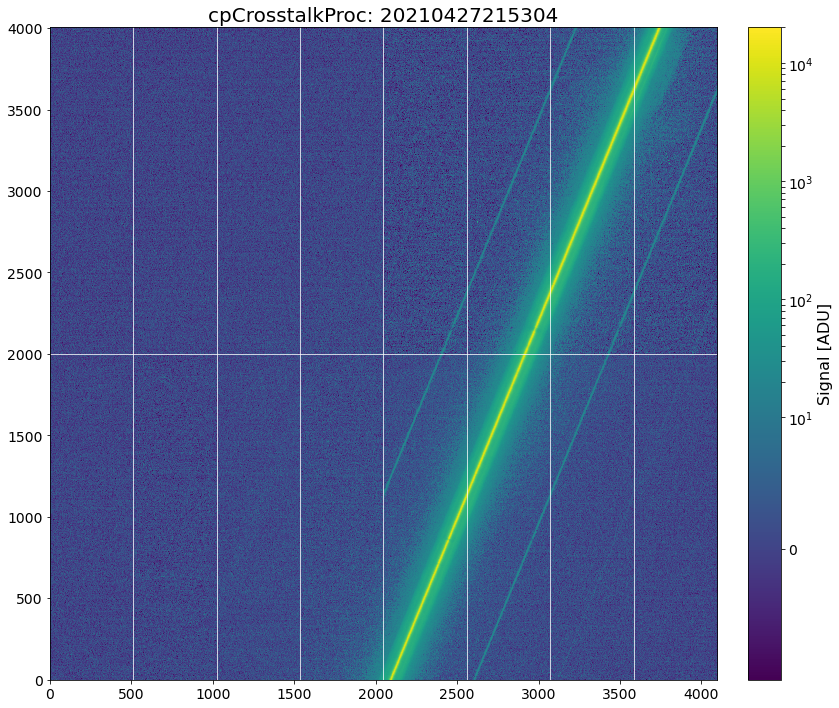

In [5]:
calexp = butler.get('cpCrosstalkProc', dataId=ref.dataId, 
                    collections='u/asnyder/satellite_20210427/crosstalk_satellite')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
im = ax.imshow(calexp.getImage().getArray(), norm=SymLogNorm(10, vmin=-10, vmax=20000, base=10), 
               interpolation='none', origin='lower')

## Overplot segment boundaries
ax.axhline(y=2002, color='white', linewidth=0.75)
for i in range(7):
    ax.axvline(x=512*(i+1), color='white', linewidth=0.75)
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('cpCrosstalkProc: {0}'.format(ref.dataId['exposure']), fontsize=20)
fig.patch.set_facecolor('white')

## 2. Identify Satellite Streak Location

In order to detect the location of the satellite streak in each amplifier, first a Canny edge detection algorithm is applied to the amplifier image to identify the edges of each side of the streak. Next, a Hough transform is performed to measure the two lines that define either side of the satellite streak.  Finally, by taking the average of the two lines, one can obtain the position of the satellite streak as a line defined by an angle and distance from the origin (Hesse normal form).

This streak identification procedure is demonstrated below, using the previously acquired calibrated exposure. The left subplot shows the results of the Canny Edge Detection applied to an amplifier image, the center plot shows the Hough transform of the Canny Edge image, and the right plot shows the original CCD amplifier image with the detected satellite streak overplotted in red.

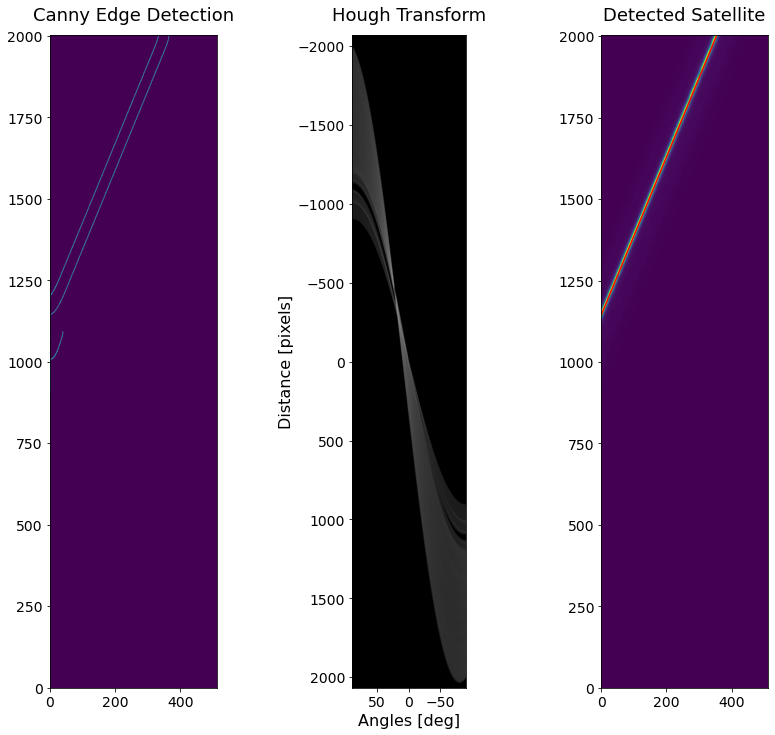

In [6]:
## Select source/target amp pair
sourceDetector = calexp.getDetector()
sourceAmp = sourceDetector[2]

## Get source amp image
sourceIm = calexp.getMaskedImage()
sourceAmpImage = sourceIm[sourceAmp.getBBox()]
sourceAmpArray = sourceAmpImage.image.array

## Perform line detection
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 1000)
edges = feature.canny(sourceAmpArray, sigma=15, low_threshold=1, high_threshold=15)
h, theta, d = hough_line(edges, theta=tested_angles)
_, angle, dist = hough_line_peaks(h, theta, d)

satellite_angle = np.mean(angle)
satellite_dist = np.mean(dist)

## Plot Canny Edge transform
fig, ax = plt.subplots(1, 3, figsize=(14, 12))
ax[0].imshow(edges, origin='lower')
ax[0].set_title('Canny Edge Detection', fontsize=18, pad=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)

## Plot Hough Transform
ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap='gray', aspect=1/4.)
ax[1].set_title('Hough Transform', fontsize=18, pad=15)
ax[1].set_xlabel('Angles [deg]', fontsize=16)
ax[1].set_ylabel('Distance [pixels]', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)

## Plot detected satellite and original segment image
ax[2].imshow(sourceAmpArray, origin='lower')

origin = np.array((0, sourceAmpArray.shape[1]-1))
y0, y1 = (satellite_dist - origin * np.cos(satellite_angle)) / np.sin(satellite_angle)
ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_title('Detected Satellite', fontsize=18, pad=15)
ax[2].set_ylim(0, 2002)
ax[2].tick_params(axis='both', which='major', labelsize=14)

fig.patch.set_facecolor('white')

## 3. Select Source/Target Regions

Using the satellite streak location, the next step is to create a mask around the satellite streak region on both the source amplifier image and the target amplifier image, shown below. This is done to isolate the regions of the CCD that will be compared in order to calculate the crosstalk ratio.

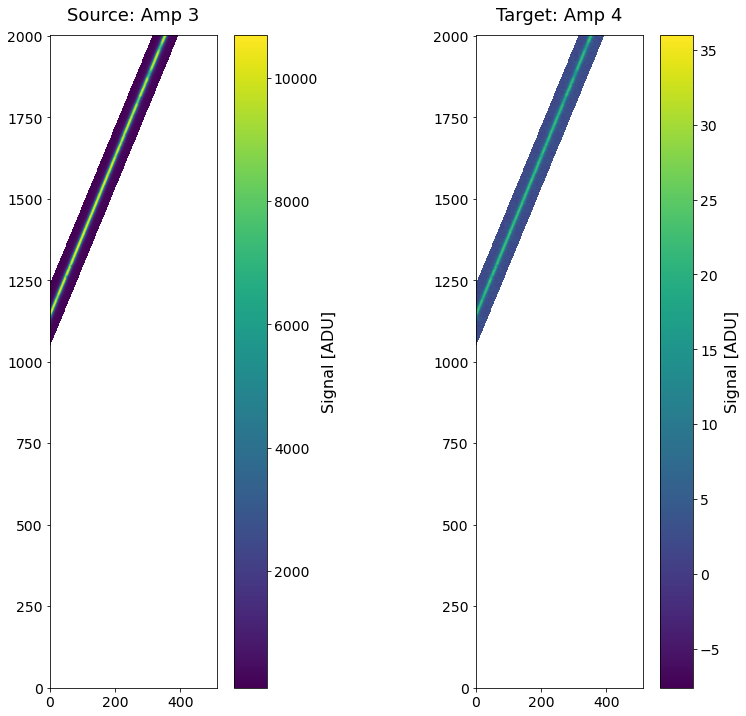

In [7]:
select = mixCrosstalk.satellite_mask(sourceAmpArray, satellite_angle, satellite_dist, width=40)
    
targetAmp = sourceDetector[3]
targetIm = calexp.getMaskedImage()
targetAmpImage = CrosstalkCalib.extractAmp(targetIm.image, targetAmp, sourceAmp, isTrimmed=True)
targetAmpArray = targetAmpImage.array

fig, ax = plt.subplots(1, 2, figsize=(14, 12))
im0 = ax[0].imshow(np.ma.MaskedArray(sourceAmpArray, mask=~select), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(targetAmpArray, mask=~select), origin='lower')

ax[0].set_title('Source: Amp {0}'.format(DAVIS_SEG2AMP[sourceAmp.getName()]), fontsize=18, pad=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.set_label('Signal [ADU]', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

ax[1].set_title('Target: Amp {0}'.format(DAVIS_SEG2AMP[targetAmp.getName()]), fontsize=18, pad=15)
ax[1].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.set_label('Signal [ADU]', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

## 4. (Optional) Determine Read Noise Covariance

A systematic source of error in this measurement methodology is the effect of correlated read noise between amplifier pairs that will bias any pixel signal comparison between the image regions, most noticeably for low source signals. In order to remove this systematic, the correlation between the read noise is removed by adding an additional noise component to each image that is equal in magnitude but with the opposite correlation as the original read noise.  The covariance between the serial overscan regions, which will be used for the correction of the read noise correlation, is calculated using the `raw` exposure, which have not been trimmed of the overscan regions. A disadvantage of this technique is that it will increase the statistical error for each crosstalk ratio measurement, thus for amplifier pairs with little correlation in read noise it can be ommitted to improve the measurement error.

Below is the result of the covariance calculation for the amplifier pairs used in this example. In the absence of this measurement, the read noise will be extracted from the source/target `lsst.afw.cameraGeom.Amplifier` objects to be used in the model parameter error estimate results.

In [8]:
covariance = mixCrosstalk.calculate_covariance(rawexp, sourceAmp, targetAmp)
print('Covariance: Amp {0}, Amp {1}\n'.format(DAVIS_SEG2AMP[sourceAmp.getName()], 
                                              DAVIS_SEG2AMP[targetAmp.getName()]), covariance)

Covariance: Amp 3, Amp 4
 [[5.675794   2.42878015]
 [2.42878015 5.53314007]]


## 5. Least Squares Minimization of Target Model

The simplest method to calculate the crosstalk ratio is to simply take a ratio of the induced signal in the target amplifier region compared to the signal in the source amplifier region. However, because of the presence of a non-uniform scattered light background it is necessary to account for this additional signal when calculating the crosstalk ratio. Therefore the method used to calculate the crosstalk ratio is to assume that, within the corresponding pixel region selected by the mask encompassing the satellite streak, the target amplifier image is the aggressor amplifier image scaled by the crosstalk ratio, plus a sloped plane scattered light background. Using this model, a least squares minimization can be performed, solving jointly for the crosstalk ratio and the scattered light background (https://arxiv.org/abs/2101.01281).

This is demonstrated below with an image of the source region on the left, the target region in the center, and the best fit model determined from the least squares minimization on the right.

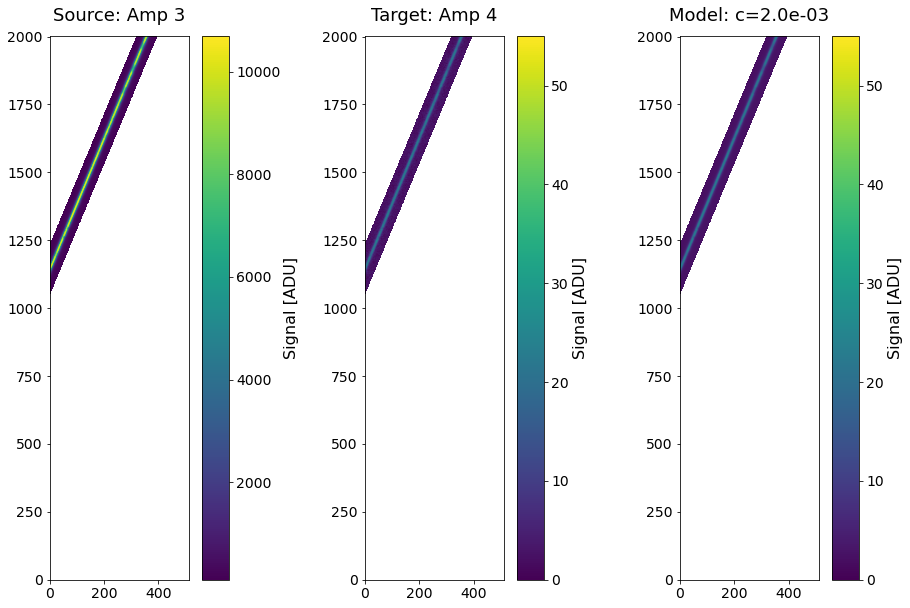

In [9]:
results = mixCrosstalk.crosstalk_fit(sourceAmpArray, targetAmpArray, select, covariance=covariance, seed=189,
                                     correct_covariance=False)
model = mixCrosstalk.crosstalk_model(results[:4], sourceAmpArray)

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
im0 = ax[0].imshow(np.ma.MaskedArray(sourceAmpArray, mask=~select), origin='lower')
im1 = ax[1].imshow(np.ma.MaskedArray(targetAmpArray, mask=~select), origin='lower', vmin=0, vmax=55)
im2 = ax[2].imshow(np.ma.MaskedArray(model, mask=~select), origin='lower', vmin=0, vmax=55)

ax[0].set_title('Source: Amp {0}'.format(DAVIS_SEG2AMP[sourceAmp.getName()]), fontsize=18, pad=15)
ax[0].tick_params(axis='both', which='major', labelsize=14)
cbar0 = fig.colorbar(im0, ax=ax[0])
cbar0.set_label('Signal [ADU]', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

ax[1].set_title('Target: Amp {0}'.format(DAVIS_SEG2AMP[targetAmp.getName()]), fontsize=18, pad=15)
ax[1].tick_params(axis='both', which='major', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax[1])
cbar1.set_label('Signal [ADU]', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

ax[2].set_title('Model: c={0:.1e}'.format(results[0]), fontsize=18, pad=15)
ax[2].tick_params(axis='both', which='major', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax[2])
cbar2.set_label('Signal [ADU]', fontsize=16)
cbar2.ax.tick_params(labelsize=14)